# AMS 520 Final Project

This notebook contains codes and report implementing 'Model high-frequency limit order book dynamics with SVM' written by Edward Cummings, Anton Malandii, Jack Peters, and Weiwei Tao.

In [247]:
!pip install -qq pyarrow
!pip install -qq xgboost

In [290]:
import functools as fn
import datetime
import math

import pandas as pd
import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

import seaborn as sns
import matplotlib.pyplot as plt


import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
    
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

## hyperparameter to control whether we are working on time-based change or event based changes
TIMEBASED = True
FREQ = 1000 ## ms, the frequency for time-based change
NEVENTS = 30 ## event-based number of events ahead

## Part 1. Data Import

### Trade dataset

The trade dataset contains 243K UTP trade records from 14 different Stock Exchanges on 2022-01-06 between 4 a.m. until 8 p.m. EST for AAPL.


### Quote dataset
The quote dataset contains 473K UTP quote records from 13 different Stock Exchanges on 2022-01-06 for AAPL.

In [291]:
t = pd.read_csv('query_trades_AAPL_20200106_born202210121745.csv',)
q = pd.read_csv('query_quotes_AAPL_20200106_born202210121744.csv',)

/var/folders/9g/k3f7lx5n4cnb1yd775c6k7bw0000gn/T/ipykernel_36502/2188346647.py:2: DtypeWarning:

Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.



In [292]:
t.shape, q.shape

((242878, 17), (473340, 31))

## Part 2. Data Cleaning

We first removed the closing/opening auction dissemination ( remove first and last 15 min) and excluded trades from the exchange D from our analysis. Then, trades and quote updates that stem from the same marketable order execution were regrouped together. We used the participant timestamp to assign a unique marketable order execution (MOX) identifier to each batch of trades and quotes triggered in execution of a single marketable order. Note that the reason that the participant timestamp can be used to derive the MOX identifier because all trades and quote updates that are triggered in the execution of the same marketable order receive the same participant (but not SIP) timestamp in high resolution.

After data cleaning, the analysis dataset contains 395K records. For each records, following features are generated:
1. Time
2. ask/bid price/volume, mid price, spread
3. dPask_dt, dPbid_dt, dVask_dt, dVbid_dt
4. average trade price/volume within 10ms, 100ms, 1s and 10s. 

In [293]:
from taq_data_cleaning import gen_basic_features_TAQ, gen_targets_events, gen_targets_temporal

In [294]:
df_features = gen_basic_features_TAQ(t, q,)

print(df_features.shape)
print(df_features.columns)
df_features.head()

/Users/weiweitao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



(395698, 20)
Index(['index', 'time', 'ask_price', 'bid_price', 'ask_volume', 'bid_volume',
       'mid_price', 'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt',
       'avg_trade_price_10ms', 'avg_trade_price_100ms', 'avg_trade_price_1s',
       'avg_trade_price_10s', 'avg_trade_volume_10ms',
       'avg_trade_volume_100ms', 'avg_trade_volume_1s',
       'avg_trade_volume_10s'],
      dtype='object')


,index,time,ask_price,bid_price,ask_volume,bid_volume,mid_price,spread,dPask_dt,dPbid_dt,dVask_dt,dVbid_dt,avg_trade_price_10ms,avg_trade_price_100ms,avg_trade_price_1s,avg_trade_price_10s,avg_trade_volume_10ms,avg_trade_volume_100ms,avg_trade_volume_1s,avg_trade_volume_10s
id,,,,,,,,,,,,,,,,,,,,
2214126,42179,35100.044580,295.08,295.04,1.0,1.0,295.060,0.04,-0.02,-0.02,0.0,-3.0,73.762500,73.7625,89.298685,97.805744,50.000000,50.000000,23.111842,20.581952
2214141,42181,35100.044763,295.07,295.04,1.0,1.0,295.055,0.03,-0.03,-0.02,0.0,-3.0,59.010000,59.0100,88.715033,97.625954,40.000000,40.000000,22.960784,20.544118
2214146,42182,35100.044834,295.06,295.04,2.0,1.0,295.050,0.02,-0.04,-0.02,1.0,-3.0,49.175000,49.1750,88.138962,97.446824,33.333333,33.333333,22.811688,20.506422
2214167,42183,35100.045857,295.06,295.04,3.0,1.0,295.050,0.02,-0.04,-0.02,2.0,-3.0,73.762500,73.7625,88.900321,97.629925,34.375000,34.375000,23.000000,20.568556
2214865,42184,35100.094862,295.06,295.04,2.0,1.0,295.050,0.02,-0.04,-0.02,1.0,-3.0,65.566667,0.0000,88.334077,97.262666,30.555556,0.000000,22.853503,20.563536


## Part 3. Generate Labels

Both event-base and time-based outcomes were evaluated. 
1. After 30 orders, whether the price and spread will go down, unchanged or up.
2. After 100 ms, whether the price and spread will go down, unchanged or up.

In [295]:
if TIMEBASED:
    df_events = gen_targets_temporal(q, prediction_interval=FREQ)
    df_events.set_index('id', inplace = True)
    df_events.rename(columns = {'midup'+str(FREQ)+'ms':'midup', 
                                 'middown'+str(FREQ)+'ms':'middown', 
                                 'mideq'+str(FREQ)+'ms':'mideq'
                            }, inplace = True)
else:
    df_events = gen_targets_events(q, num_events=NEVENTS)
    df_events.set_index('id', inplace = True)
    
df_combine = pd.merge(df_events, df_features, left_index=True, right_index=True)
df_events.shape, df_features.shape, df_combine.shape

/Users/weiweitao/Desktop/Stony Brook/2022 Fall Courses/AMS 520 ML in Finance/Project/Predicting-Price-Movement-and-Spread-Crossing-using-Machine-Learning-Methods-main/taq_data_cleaning.py:294: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



((395692, 8), (395698, 20), (395692, 28))

In [296]:
df_combine.head()

,index_x,time_x,midup,middown,mideq,spreadup1000ms,spreaddown1000ms,spreadeq1000ms,index_y,time_y,...,dVask_dt,dVbid_dt,avg_trade_price_10ms,avg_trade_price_100ms,avg_trade_price_1s,avg_trade_price_10s,avg_trade_volume_10ms,avg_trade_volume_100ms,avg_trade_volume_1s,avg_trade_volume_10s
id,,,,,,,,,,,,,,,,,,,,,
2214126,0,35100.044580,False,True,False,False,False,True,42179,35100.044580,...,0.0,-3.0,73.762500,73.7625,89.298685,97.805744,50.000000,50.000000,23.111842,20.581952
2214141,1,35100.044763,False,True,False,False,False,True,42181,35100.044763,...,0.0,-3.0,59.010000,59.0100,88.715033,97.625954,40.000000,40.000000,22.960784,20.544118
2214146,2,35100.044834,False,False,True,False,False,True,42182,35100.044834,...,1.0,-3.0,49.175000,49.1750,88.138962,97.446824,33.333333,33.333333,22.811688,20.506422
2214167,3,35100.045857,False,False,True,False,False,True,42183,35100.045857,...,2.0,-3.0,73.762500,73.7625,88.900321,97.629925,34.375000,34.375000,23.000000,20.568556
2214865,4,35100.094862,False,False,True,False,False,True,42184,35100.094862,...,1.0,-3.0,65.566667,0.0000,88.334077,97.262666,30.555556,0.000000,22.853503,20.563536


## Part 4. Data Visualization

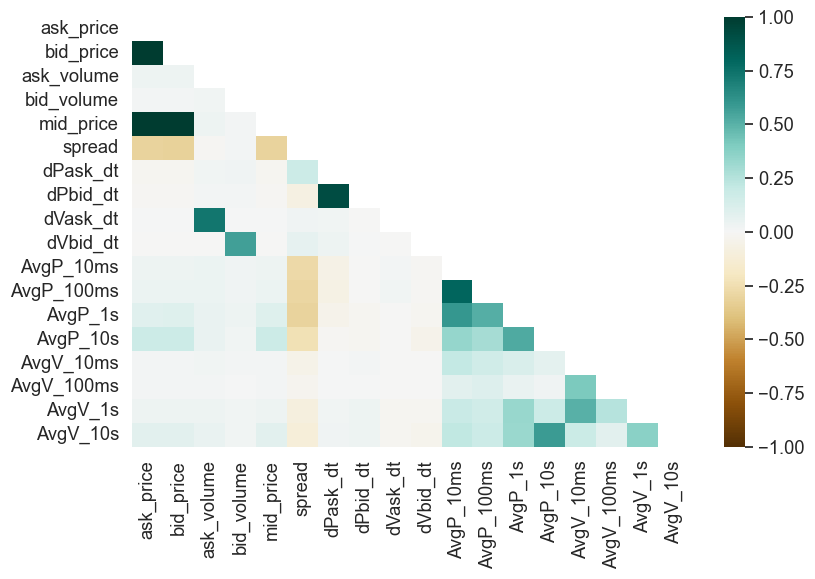

In [297]:
df_combine.rename(columns = {'avg_trade_price_10ms':'AvgP_10ms', 
                             'avg_trade_price_100ms':'AvgP_100ms', 
                             'avg_trade_price_1s':'AvgP_1s', 
                             'avg_trade_price_10s':'AvgP_10s', 
                             'avg_trade_volume_10ms':'AvgV_10ms', 
                             'avg_trade_volume_100ms':'AvgV_100ms', 
                             'avg_trade_volume_1s':'AvgV_1s', 
                             'avg_trade_volume_10s':'AvgV_10s', 
                            }, inplace = True)

focus_columns = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 
                 'mid_price', 'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt', 
                 'AvgP_10ms', 'AvgP_100ms', 'AvgP_1s', 'AvgP_10s', 
                 'AvgV_10ms', 'AvgV_100ms', 'AvgV_1s', 'AvgV_10s']

corr=df_combine[focus_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

heat_fig, (ax)=plt.subplots(1, 1, figsize=(8,5))

heat=sns.heatmap(corr, 
                   ax=ax,  
                   mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')

heat_fig.subplots_adjust(top=.93)

In [298]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n=5):
    au_corr = corr.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr, 10))

Top Absolute Correlations
bid_price   mid_price     0.999991
ask_price   mid_price     0.999991
            bid_price     0.999965
dPask_dt    dPbid_dt      0.918266
AvgP_10ms   AvgP_100ms    0.798827
ask_volume  dVask_dt      0.728240
AvgP_10ms   AvgP_1s       0.600992
AvgP_10s    AvgV_10s      0.585196
bid_volume  dVbid_dt      0.567890
AvgP_1s     AvgP_10s      0.529059
dtype: float64


array([[<AxesSubplot:xlabel='Time of the Day'>,
        <AxesSubplot:xlabel='Time of the Day'>,
        <AxesSubplot:xlabel='Time of the Day'>],
       [<AxesSubplot:xlabel='Time of the Day'>,
        <AxesSubplot:xlabel='Time of the Day'>,
        <AxesSubplot:xlabel='Time of the Day'>]], dtype=object)

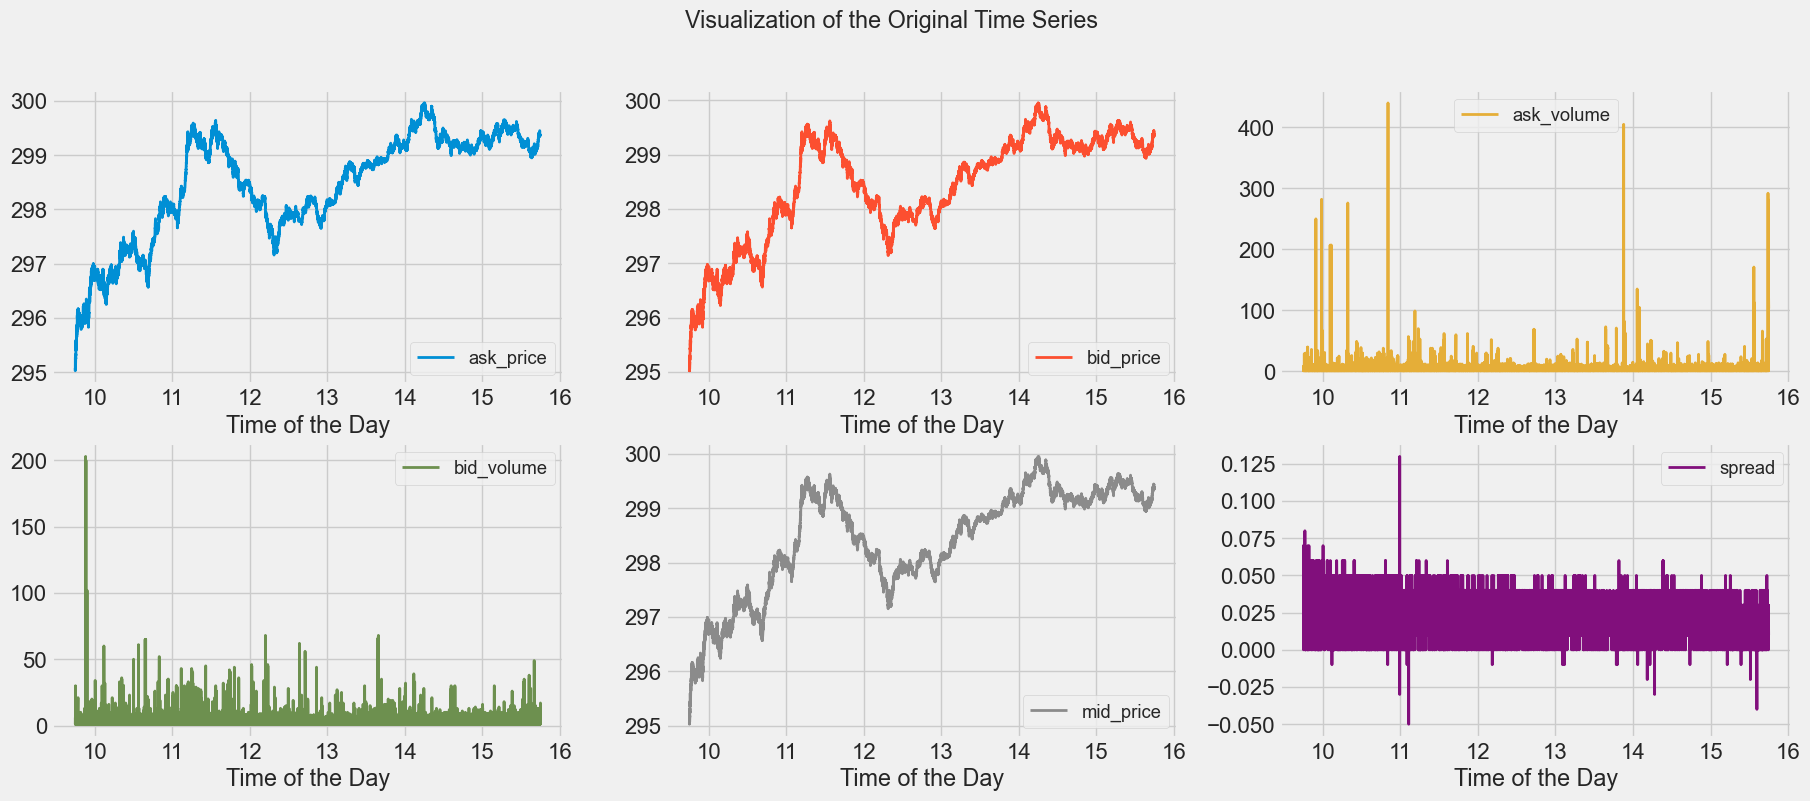

In [299]:
df_features['hour'] = df_features['time']/3600
df_features.set_index('hour', inplace = True)
cols = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 'mid_price', 'spread']

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


plt.style.use('fivethirtyeight')
df_features[cols].plot(subplots=True, figsize=(20, 8),fontsize=16, sharex=False, layout=(2, 3),  linewidth=2, 
                       xlabel = 'Time of the Day', title='Visualization of the Original Time Series')

## Part 5. Train-Test Splitting

In [300]:
df_combine.loc[df_combine['midup'] == True, 'ymid'] = 'Up'
df_combine.loc[df_combine['mideq'] == True, 'ymid'] = 'Equal'
df_combine.loc[df_combine['middown'] == True, 'ymid'] = 'Down'

encoder = LabelEncoder()
df_combine['y'] = encoder.fit_transform(df_combine['ymid'])

print(df_combine.shape)
df_combine['y'].value_counts()

(395692, 30)


1    263111
0     70474
2     62107
Name: y, dtype: int64

In [301]:
nidx = int(df_combine.shape[0]*0.8)

df_train = df_combine.iloc[:nidx]
df_test = df_combine.iloc[nidx:]
df_test.shape, df_train.shape

((79139, 30), (316553, 30))

### Data Resampling - Downsample the majority class (Time based case)

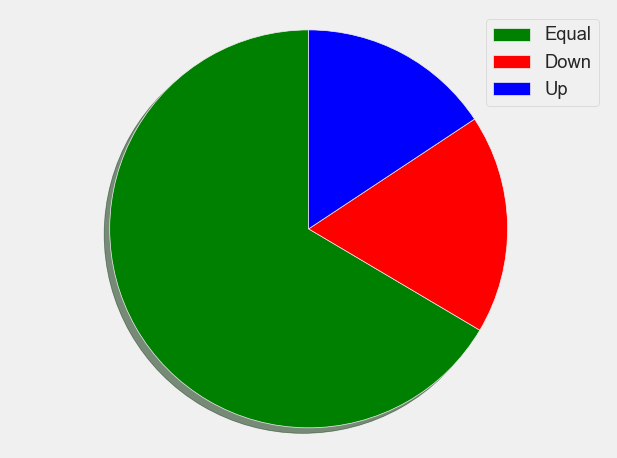

In [303]:
temp = df_combine['ymid'].value_counts()

labels = temp.index.values
sizes = temp
colors = ['green', 'red', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [302]:
dfup = df_train.loc[df_combine['midup'] == True]
dfeq = df_train.loc[df_combine['mideq'] == True]
dfdown = df_train.loc[df_combine['middown'] == True]

dfup.shape, dfeq.shape, dfdown.shape

((51195, 30), (207888, 30), (57470, 30))

In [230]:
from sklearn.utils import resample
dfeq_ds = resample(dfeq, replace=False, n_samples=50000, random_state=42)
df_train_final = pd.concat([dfup, dfdown, dfeq_ds], axis = 0)

### Data Resampling - Downsample the majority class (Event based case)

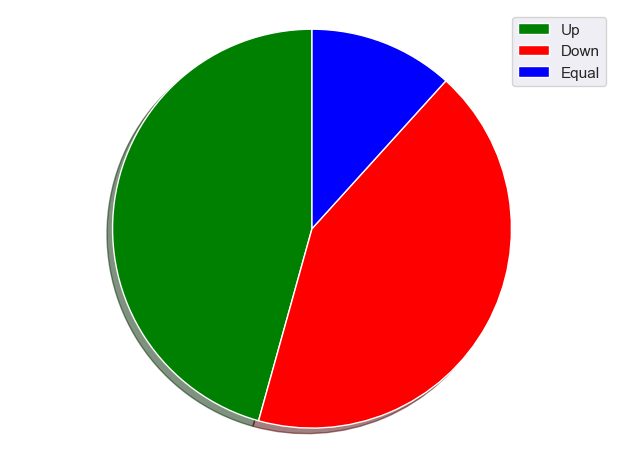

In [289]:
temp = df_combine['ymid'].value_counts()

labels = temp.index.values
sizes = temp
colors = ['green', 'red', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [270]:
dfup = df_train.loc[df_combine['midup'] == True]
dfeq = df_train.loc[df_combine['mideq'] == True]
dfdown = df_train.loc[df_combine['middown'] == True]

dfup.shape, dfeq.shape, dfdown.shape

((145760, 30), (35538, 30), (135236, 30))

In [271]:
from sklearn.utils import resample
dfup_ds = resample(dfup, replace=False, n_samples=35000, random_state=42)
dfdown_ds = resample(dfdown, replace=False, n_samples=35000, random_state=42)
df_train_final = pd.concat([dfup_ds, dfdown_ds, dfeq], axis = 0)

In [272]:
X_train = df_train_final[focus_columns]
y_train = df_train_final['y']

X_test = df_test[focus_columns]
y_test = df_test['y']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105538, 18), (79134, 18), (105538,), (79134,))

In [273]:
y_train.value_counts()

1    35538
2    35000
0    35000
Name: y, dtype: int64

In [274]:
y_test.value_counts()

2    34990
0    33339
1    10805
Name: y, dtype: int64

## Part 5. Build Classification Models

### XGBoost Model

In [275]:
def plot_confusion_matrix(y_test,y_scores, classNames):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.0) # for label size
    ax = sns.heatmap(con, annot=True, fmt='.2', cmap='Blues', xticklabels= classNames , yticklabels= classNames)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

In [276]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [236]:
## Search for the best parameters
max_depth = [7, 20]
n_estimators = [100, 300, 1000] 
result_xg = pd.DataFrame(columns = ['max_depth', 'n_estimators',
                                 'reg_alpha', 'accuracy'])
for d in max_depth:
    for ne in n_estimators:
            xgb1 = XGBClassifier(
             learning_rate =0.05,
             n_estimators=ne, # number of gradient boosting trees
             max_depth=d,
             gamma=0.6,
             subsample=0.8, 
             colsample_bytree=0.7, # 0.5-0.9
             objective='multi:softmax',
             nthread=-1,
             seed=27)
                
            xgb1.fit(X_train, y_train, sample_weight=classes_weights)
            report = classification_report(y_test, xgb1.predict(X_test), output_dict=True)

            res =  pd.DataFrame({"max_depth": [d], "n_estimators": [ne], 
                                 "reg_alpha": [r],
                                "accuracy": report['accuracy']
                                })
            print(res)
            result_xg = pd.concat([result_xg, res], axis = 0)
            
result_xg

   max_depth  n_estimators  reg_alpha  accuracy
0          7           100          0  0.586601
   max_depth  n_estimators  reg_alpha  accuracy
0          7           300          0  0.590126
   max_depth  n_estimators  reg_alpha  accuracy
0          7          1000          0  0.593399
   max_depth  n_estimators  reg_alpha  accuracy
0         20           100          0  0.593487
   max_depth  n_estimators  reg_alpha  accuracy
0         20           300          0  0.599313


KeyboardInterrupt: 

### Event based results

In [240]:
xgb_best = XGBClassifier(
 learning_rate =0.05,
 n_estimators=300, # number of gradient boosting trees
 max_depth=20,
 gamma=0.6,
 subsample=0.8, 
 colsample_bytree=0.7, # 0.5-0.9
 objective='multi:softmax',
 nthread=-1,
 seed=27)
xgb_best.fit(X_train, y_train)

xgb_predict = xgb_best.predict(X_test)

**** Confusion Matrix ****
[[ 7521  3838  1645]
 [11999 34375  8849]
 [ 2100  3761  5051]]
**** Classification Report ****
              precision    recall  f1-score   support

        Down       0.35      0.58      0.43     13004
       Equal       0.82      0.62      0.71     55223
          Up       0.32      0.46      0.38     10912

    accuracy                           0.59     79139
   macro avg       0.50      0.55      0.51     79139
weighted avg       0.67      0.59      0.62     79139



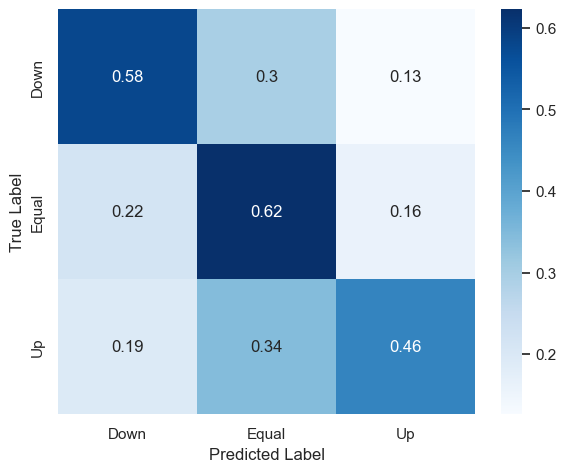

In [243]:
classNames = ['Down', 'Equal', 'Up'] 
plot_confusion_matrix(y_test,xgb_predict, classNames) 

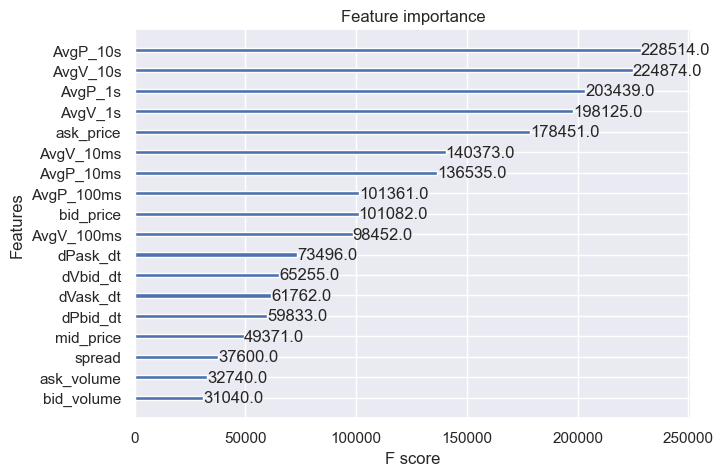

In [246]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xgb_best)
plt.show()

### Time based results

In [277]:
xgb_best = XGBClassifier(
 learning_rate =0.05,
 n_estimators=300, # number of gradient boosting trees
 max_depth=20,
 gamma=0.6,
 subsample=0.8, 
 colsample_bytree=0.7, # 0.5-0.9
 objective='multi:softmax',
 nthread=-1,
 seed=27)
xgb_best.fit(X_train, y_train)

xgb_predict = xgb_best.predict(X_test)

**** Classification Report ****
              precision    recall  f1-score   support

        Down       0.48      0.54      0.51     33339
       Equal       0.14      0.13      0.14     10805
          Up       0.49      0.44      0.46     34990

    accuracy                           0.44     79134
   macro avg       0.37      0.37      0.37     79134
weighted avg       0.44      0.44      0.44     79134



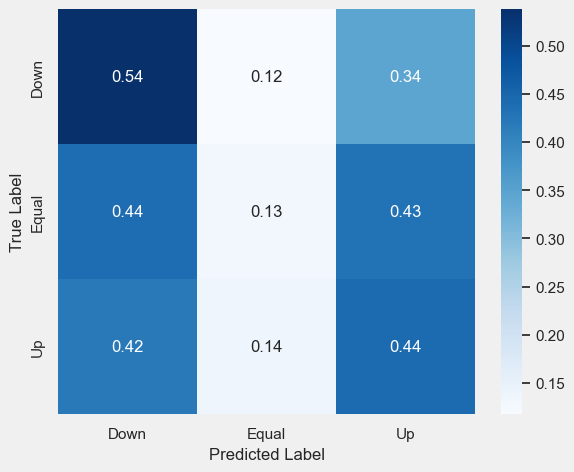

In [278]:
classNames = ['Down', 'Equal', 'Up'] 
plot_confusion_matrix(y_test,xgb_predict, classNames) 

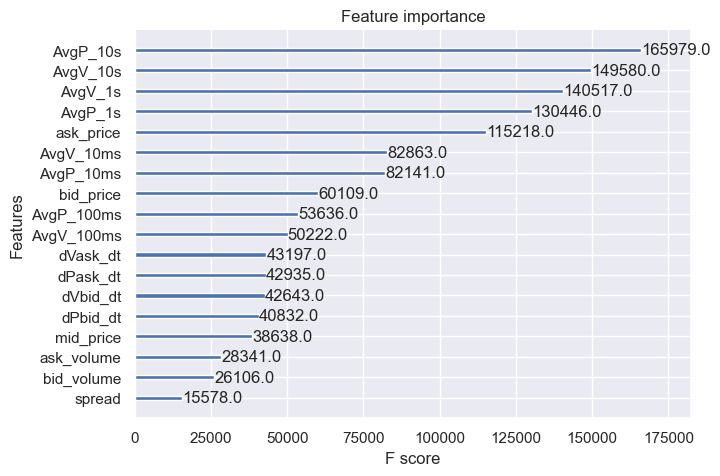

In [280]:
# plot feature importance
plot_importance(xgb_best)
plt.show()